# TP2 - Aprendizaje Profundo: Solución

## Nombre: Christian Ricardo Conchari Cabrera
## Cohorte: 15Co2024

# Importación de librerias

In [159]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import os
from tqdm import tqdm

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report

Verificar la disponibilidad de cuda

In [96]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Generación del dataset

Se define un dataset que solamente contenga las clases seleccionadas.

In [97]:
class FilteredDataset(Dataset):
  def __init__(self, original_dataset, selected_labels):
    """
    Initialize the FilteredDataset with the original dataset and selected labels.

    Parameters:
    - original_dataset: The original dataset.
    - selected_labels: A list of labels to filter the dataset.
    """
    # Store the original dataset and selected labels
    self.original_dataset = original_dataset
    self.selected_labels = selected_labels

    # Create a dictionary to remap selected labels to ascending indices
    self.label_map = {label: idx for idx, label in enumerate(selected_labels)}

    # Filter the indices of the images that belong to the selected classes
    self.indices = [i for i, label in enumerate(original_dataset.targets) if label in selected_labels]

  def __len__(self):
    """
    Get the length of the filtered dataset.

    Returns:
    - The length of the filtered dataset.
    """
    # Return the length of the filtered dataset
    return len(self.indices)

  def __getitem__(self, idx):
    """
    Get an item from the filtered dataset.

    Parameters:
    - idx: The index of the item to retrieve.

    Returns:
    - A tuple containing the image and the remapped label.
    """
    # Get the index of the original dataset
    original_idx = self.indices[idx]

    # Get the corresponding image and label from the original dataset
    image, label = self.original_dataset[original_idx]

    # Remap the label using the label_map dictionary
    remapped_label = self.label_map[label]

    # Return the image and the remapped label
    return image, remapped_label

Definimos las transformaciones que se aplicarán sobre las imágenes

In [98]:
transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

Descargar y cargar el conjunto de datos CIFAR-10

In [99]:
original_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
original_test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


Se seleccionan 3 clases: gato, perro, rana

In [100]:
classes = original_train_dataset.classes
selected_classes = ['cat', 'dog', 'frog']
selected_class_indices = [classes.index(cls) for cls in selected_classes]

Se creará un nuevo conjunto de datos con las clases seleccionadas

In [101]:
filtered_train_dataset = FilteredDataset(original_train_dataset, selected_class_indices)
filtered_test_dataset = FilteredDataset(original_test_dataset, selected_class_indices)

Se visualiza el tamaño de los conjuntos de datos

In [118]:
print(f'Original train dataset: {len(original_train_dataset)} images')
print(f'Filtered train dataset: {len(filtered_train_dataset)} images')

Original train dataset: 50000 images
Filtered train dataset: 15000 images


In [119]:
print(f'Original test dataset: {len(original_test_dataset)} images')
print(f'Filtered test dataset: {len(filtered_test_dataset)} images')

Original test dataset: 10000 images
Filtered test dataset: 3000 images


Se crean `DataLoaders` para los nuevos datasets con un tamaño de batch de 64

In [102]:
# Define the batch size
batch_size = 16

# Create DataLoaders for the new datasets
trainloader = DataLoader(filtered_train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(filtered_test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Se define una función para mostrar una imagen



In [103]:
def imshow(img):
  """
  Display an image tensor.

  Parameters:
  - img: The image tensor to display.
  """
  # De-normalize the image
  img = img / 2 + 0.5  
  # Convert the image tensor to a NumPy array
  npimg = img.numpy()  
  # Transpose the dimensions and display the image
  plt.imshow(np.transpose(npimg, (1, 2, 0)))  
  
  plt.show()

Se genera un lote de imágenes y se las muestra

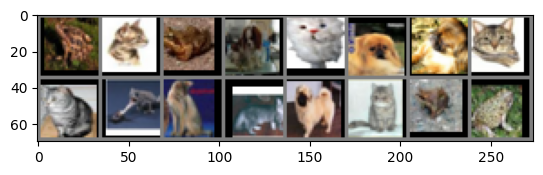

frog cat frog dog cat dog dog cat cat frog cat cat dog cat frog frog


In [104]:
# Get a batch of training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Display images from the batch
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{selected_classes[labels[j]]}' for j in range(batch_size)))

# Implementación de la arquitectura CNN

In [105]:
class CNN(torch.nn.Module):
    def __init__(self, n_classes=3, n_outputs=3, kernel_size=5):
        """
        Initialize the CNN model.
        
        Parameters:
        - n_classes: The number of input channels.
        - n_outputs: The number of output classes.
        - kernel_size: The size of the convolutional kernels.
        """
        super(CNN, self).__init__()

        # Define the convolutional layers
        self.conv1 = torch.nn.Conv2d(n_classes, 64, kernel_size=kernel_size, padding=kernel_size//2, stride=1)
        self.bn1 = torch.nn.BatchNorm2d(64)
        self.relu1 = torch.nn.LeakyReLU()
        self.maxpool1 = torch.nn.MaxPool2d((2, 2))

        self.conv2 = torch.nn.Conv2d(64, 128, kernel_size=kernel_size, padding=kernel_size//2, stride=1)
        self.bn2 = torch.nn.BatchNorm2d(128)
        self.relu2 = torch.nn.LeakyReLU()
        self.maxpool2 = torch.nn.MaxPool2d((2, 2))
        self.dropout2 = torch.nn.Dropout(0.3)

        self.conv3 = torch.nn.Conv2d(128, 256, kernel_size=kernel_size, padding=kernel_size//2, stride=1)
        self.bn3 = torch.nn.BatchNorm2d(256)
        self.relu3 = torch.nn.LeakyReLU()
        self.maxpool3 = torch.nn.MaxPool2d((2, 2))
        self.dropout3 = torch.nn.Dropout(0.3)

        self.conv4 = torch.nn.Conv2d(256, 256, kernel_size=kernel_size, padding=kernel_size//2, stride=1)
        self.bn4 = torch.nn.BatchNorm2d(256)
        self.relu4 = torch.nn.LeakyReLU()
        self.maxpool4 = torch.nn.MaxPool2d((2, 2))
        self.dropout4 = torch.nn.Dropout(0.3)

        # Define the global average pooling layer
        self.gap = torch.nn.AdaptiveAvgPool2d((1, 1))

        # Define the fully-connected layers
        self.linear = torch.nn.Linear(256, 64)
        self.dropout5 = torch.nn.Dropout(0.4)
        self.relu5 = torch.nn.LeakyReLU()
        self.linear2 = torch.nn.Linear(64, n_outputs)
        
    def forward(self, x):
        """
        Forward pass of the CNN model.
        
        Parameters:
        - x: The input image batch.
        
        Returns:
        - The output of the CNN model.
        """
        # Apply the convolutional layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.dropout2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        x = self.dropout3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.maxpool4(x)
        x = self.dropout4(x)

        # Apply the global average pooling layer
        x = self.gap(x)

        # Flatten the output of the convolutional layers
        x = x.view(x.size(0), -1)
        
        # Apply the fully-connected layers
        x = self.linear(x)
        x = self.relu5(x)
        x = self.dropout5(x)
        x = self.linear2(x)

        return x

Se muestra la arquitectura de la red neuronal convolucional que se implementará

In [106]:
model = CNN()

model.to(device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           4,864
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         LeakyReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 16, 16]         204,928
       BatchNorm2d-6          [-1, 128, 16, 16]             256
         LeakyReLU-7          [-1, 128, 16, 16]               0
         MaxPool2d-8            [-1, 128, 8, 8]               0
           Dropout-9            [-1, 128, 8, 8]               0
           Conv2d-10            [-1, 256, 8, 8]         819,456
      BatchNorm2d-11            [-1, 256, 8, 8]             512
        LeakyReLU-12            [-1, 256, 8, 8]               0
        MaxPool2d-13            [-1, 256, 4, 4]               0
          Dropout-14            [-1, 25

Se define la función de entrenamiento

In [109]:
def fit(model, dataloader, epochs=15):
    """
    Train the model using the given data.
    
    Parameters:
    - model: The model to train.
    - dataloader: The DataLoader object containing the training data.
    - epochs: The number of epochs for training.
    
    Returns:
    - A dictionary containing the training and validation metrics.
    """
    # Move the model to the device
    model.to(device)
    
    # Define the optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)
    criterion = torch.nn.CrossEntropyLoss()

    # Lists to store the metrics for each epoch
    epoch_t_loss = []
    epoch_v_loss = []
    epoch_t_acc = []
    epoch_v_acc = []

    for epoch in range(1, epochs+1):
        # Set the model to train mode
        model.train()
        
        # Initialize the training loss and number of correct predictions
        train_loss = []
        train_acc = []

        for batch in tqdm(dataloader['train'], desc=f"Training Epoch {epoch}/{epochs}"):
            # Get the input data and move it to the device
            X, y = batch
            X, y = X.to(device), y.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            y_hat = model(X)
            
            # Calculate the loss
            loss = criterion(y_hat, y)
            
            # Backward pass
            loss.backward()
            
            # Update the weights
            optimizer.step()
            
            # Store the loss and accuracy for this batch
            train_loss.append(loss.item())
            acc = (y_hat.argmax(dim=1) == y).sum().item() / len(y)
            train_acc.append(acc)

        # Calculate and store the average training loss and accuracy for this epoch
        avg_train_loss = sum(train_loss) / len(train_loss)
        avg_train_acc = sum(train_acc) / len(train_acc)
        epoch_t_loss.append(avg_train_loss)
        epoch_t_acc.append(avg_train_acc)

        # Set the model to evaluation mode
        model.eval()
        
        # Initialize the validation loss and number of correct predictions
        val_loss = []
        val_acc = []

        # Disable gradient computation
        with torch.no_grad():
            for batch in tqdm(dataloader['test'], desc="Validating", leave=False):
                # Get the input data and move it to the device
                X, y = batch
                X, y = X.to(device), y.to(device)
                
                # Forward pass
                y_hat = model(X)
                
                # Calculate the loss
                loss = criterion(y_hat, y)
                
                # Store the loss and accuracy for this batch
                val_loss.append(loss.item())
                acc = (y_hat.argmax(dim=1) == y).sum().item() / len(y)
                val_acc.append(acc)

        # Calculate and store the average validation loss and accuracy for this epoch
        avg_val_loss = sum(val_loss) / len(val_loss)
        avg_val_acc = sum(val_acc) / len(val_acc)
        epoch_v_loss.append(avg_val_loss)
        epoch_v_acc.append(avg_val_acc)

        # Print the summary after each epoch
        print(f"Epoch {epoch}/{epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {avg_train_acc:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | Val Acc: {avg_val_acc:.4f}")

    return {
        'train_loss': epoch_t_loss,
        'val_loss': epoch_v_loss,
        'train_acc': epoch_t_acc,
        'val_acc': epoch_v_acc
    }

# Experimento con tamaño de kernel 3x3

A continuación, se entrenará el modelo partiendo con el `kernel_size=3` y se evaluará su comportamiento en términos de la pérdida y *accuracy*.

In [110]:
model = CNN()
history = fit(model, {'train': trainloader, 'test': testloader}, epochs=100)

Training Epoch 1/100:   0%|          | 0/938 [00:00<?, ?it/s]

Training Epoch 1/100: 100%|██████████| 938/938 [00:05<00:00, 185.02it/s]


Epoch 1/100 | Train Loss: 0.8706 | Train Acc: 0.5681 | Val Loss: 0.7647 | Val Acc: 0.6330


Training Epoch 2/100: 100%|██████████| 938/938 [00:04<00:00, 195.18it/s]


Epoch 2/100 | Train Loss: 0.7629 | Train Acc: 0.6354 | Val Loss: 0.7211 | Val Acc: 0.6559


Training Epoch 3/100: 100%|██████████| 938/938 [00:04<00:00, 198.07it/s]


Epoch 3/100 | Train Loss: 0.7255 | Train Acc: 0.6656 | Val Loss: 0.6637 | Val Acc: 0.6928


Training Epoch 4/100: 100%|██████████| 938/938 [00:04<00:00, 202.08it/s]


Epoch 4/100 | Train Loss: 0.6839 | Train Acc: 0.6888 | Val Loss: 0.6175 | Val Acc: 0.7274


Training Epoch 5/100: 100%|██████████| 938/938 [00:04<00:00, 195.88it/s]


Epoch 5/100 | Train Loss: 0.6625 | Train Acc: 0.7009 | Val Loss: 0.6635 | Val Acc: 0.6852


Training Epoch 6/100: 100%|██████████| 938/938 [00:04<00:00, 202.15it/s]


Epoch 6/100 | Train Loss: 0.6318 | Train Acc: 0.7193 | Val Loss: 0.5772 | Val Acc: 0.7414


Training Epoch 7/100: 100%|██████████| 938/938 [00:04<00:00, 205.40it/s]


Epoch 7/100 | Train Loss: 0.6060 | Train Acc: 0.7318 | Val Loss: 0.5726 | Val Acc: 0.7490


Training Epoch 8/100: 100%|██████████| 938/938 [00:04<00:00, 203.17it/s]


Epoch 8/100 | Train Loss: 0.5932 | Train Acc: 0.7429 | Val Loss: 0.5469 | Val Acc: 0.7673


Training Epoch 9/100: 100%|██████████| 938/938 [00:04<00:00, 201.18it/s]


Epoch 9/100 | Train Loss: 0.5742 | Train Acc: 0.7461 | Val Loss: 0.5329 | Val Acc: 0.7620


Training Epoch 10/100: 100%|██████████| 938/938 [00:04<00:00, 204.04it/s]


Epoch 10/100 | Train Loss: 0.5467 | Train Acc: 0.7645 | Val Loss: 0.5028 | Val Acc: 0.7689


Training Epoch 11/100: 100%|██████████| 938/938 [00:04<00:00, 204.61it/s]


Epoch 11/100 | Train Loss: 0.5456 | Train Acc: 0.7679 | Val Loss: 0.5246 | Val Acc: 0.7666


Training Epoch 12/100: 100%|██████████| 938/938 [00:04<00:00, 201.92it/s]


Epoch 12/100 | Train Loss: 0.5290 | Train Acc: 0.7728 | Val Loss: 0.4719 | Val Acc: 0.7906


Training Epoch 13/100: 100%|██████████| 938/938 [00:04<00:00, 203.96it/s]


Epoch 13/100 | Train Loss: 0.5146 | Train Acc: 0.7797 | Val Loss: 0.4784 | Val Acc: 0.7922


Training Epoch 14/100: 100%|██████████| 938/938 [00:04<00:00, 206.96it/s]


Epoch 14/100 | Train Loss: 0.5113 | Train Acc: 0.7820 | Val Loss: 0.5008 | Val Acc: 0.7829


Training Epoch 15/100: 100%|██████████| 938/938 [00:04<00:00, 201.73it/s]


Epoch 15/100 | Train Loss: 0.4991 | Train Acc: 0.7882 | Val Loss: 0.4629 | Val Acc: 0.7939


Training Epoch 16/100: 100%|██████████| 938/938 [00:04<00:00, 202.42it/s]


Epoch 16/100 | Train Loss: 0.4916 | Train Acc: 0.7956 | Val Loss: 0.4906 | Val Acc: 0.7989


Training Epoch 17/100: 100%|██████████| 938/938 [00:05<00:00, 167.22it/s]


Epoch 17/100 | Train Loss: 0.4824 | Train Acc: 0.7961 | Val Loss: 0.4916 | Val Acc: 0.7849


Training Epoch 18/100: 100%|██████████| 938/938 [00:05<00:00, 162.02it/s]


Epoch 18/100 | Train Loss: 0.4714 | Train Acc: 0.8026 | Val Loss: 0.4415 | Val Acc: 0.8068


Training Epoch 19/100: 100%|██████████| 938/938 [00:05<00:00, 159.49it/s]


Epoch 19/100 | Train Loss: 0.4678 | Train Acc: 0.8013 | Val Loss: 0.4713 | Val Acc: 0.8009


Training Epoch 20/100: 100%|██████████| 938/938 [00:05<00:00, 164.24it/s]


Epoch 20/100 | Train Loss: 0.4618 | Train Acc: 0.8050 | Val Loss: 0.4375 | Val Acc: 0.8142


Training Epoch 21/100: 100%|██████████| 938/938 [00:05<00:00, 166.46it/s]


Epoch 21/100 | Train Loss: 0.4559 | Train Acc: 0.8098 | Val Loss: 0.4494 | Val Acc: 0.8078


Training Epoch 22/100: 100%|██████████| 938/938 [00:05<00:00, 165.31it/s]


Epoch 22/100 | Train Loss: 0.4530 | Train Acc: 0.8101 | Val Loss: 0.4479 | Val Acc: 0.8112


Training Epoch 23/100: 100%|██████████| 938/938 [00:05<00:00, 171.11it/s]


Epoch 23/100 | Train Loss: 0.4421 | Train Acc: 0.8140 | Val Loss: 0.4187 | Val Acc: 0.8195


Training Epoch 24/100: 100%|██████████| 938/938 [00:05<00:00, 171.68it/s]


Epoch 24/100 | Train Loss: 0.4326 | Train Acc: 0.8196 | Val Loss: 0.4174 | Val Acc: 0.8298


Training Epoch 25/100: 100%|██████████| 938/938 [00:05<00:00, 171.10it/s]


Epoch 25/100 | Train Loss: 0.4374 | Train Acc: 0.8187 | Val Loss: 0.4025 | Val Acc: 0.8308


Training Epoch 26/100: 100%|██████████| 938/938 [00:05<00:00, 167.42it/s]


Epoch 26/100 | Train Loss: 0.4249 | Train Acc: 0.8199 | Val Loss: 0.4124 | Val Acc: 0.8221


Training Epoch 27/100: 100%|██████████| 938/938 [00:04<00:00, 203.10it/s]


Epoch 27/100 | Train Loss: 0.4190 | Train Acc: 0.8298 | Val Loss: 0.4092 | Val Acc: 0.8205


Training Epoch 28/100: 100%|██████████| 938/938 [00:05<00:00, 173.23it/s]


Epoch 28/100 | Train Loss: 0.4165 | Train Acc: 0.8282 | Val Loss: 0.4019 | Val Acc: 0.8348


Training Epoch 29/100: 100%|██████████| 938/938 [00:05<00:00, 171.42it/s]


Epoch 29/100 | Train Loss: 0.4146 | Train Acc: 0.8278 | Val Loss: 0.4231 | Val Acc: 0.8285


Training Epoch 30/100: 100%|██████████| 938/938 [00:05<00:00, 167.52it/s]


Epoch 30/100 | Train Loss: 0.4055 | Train Acc: 0.8317 | Val Loss: 0.3931 | Val Acc: 0.8321


Training Epoch 31/100: 100%|██████████| 938/938 [00:05<00:00, 167.38it/s]


Epoch 31/100 | Train Loss: 0.3992 | Train Acc: 0.8373 | Val Loss: 0.4356 | Val Acc: 0.8175


Training Epoch 32/100: 100%|██████████| 938/938 [00:05<00:00, 168.21it/s]


Epoch 32/100 | Train Loss: 0.3930 | Train Acc: 0.8415 | Val Loss: 0.3859 | Val Acc: 0.8364


Training Epoch 33/100: 100%|██████████| 938/938 [00:04<00:00, 199.17it/s]


Epoch 33/100 | Train Loss: 0.4005 | Train Acc: 0.8370 | Val Loss: 0.4372 | Val Acc: 0.8231


Training Epoch 34/100: 100%|██████████| 938/938 [00:04<00:00, 196.92it/s]


Epoch 34/100 | Train Loss: 0.3889 | Train Acc: 0.8393 | Val Loss: 0.4246 | Val Acc: 0.8231


Training Epoch 35/100: 100%|██████████| 938/938 [00:04<00:00, 201.19it/s]


Epoch 35/100 | Train Loss: 0.3881 | Train Acc: 0.8359 | Val Loss: 0.3956 | Val Acc: 0.8328


Training Epoch 36/100: 100%|██████████| 938/938 [00:04<00:00, 196.80it/s]


Epoch 36/100 | Train Loss: 0.3778 | Train Acc: 0.8495 | Val Loss: 0.3744 | Val Acc: 0.8404


Training Epoch 37/100: 100%|██████████| 938/938 [00:04<00:00, 202.57it/s]


Epoch 37/100 | Train Loss: 0.3745 | Train Acc: 0.8471 | Val Loss: 0.3697 | Val Acc: 0.8514


Training Epoch 38/100: 100%|██████████| 938/938 [00:04<00:00, 205.19it/s]


Epoch 38/100 | Train Loss: 0.3669 | Train Acc: 0.8532 | Val Loss: 0.3876 | Val Acc: 0.8438


Training Epoch 39/100: 100%|██████████| 938/938 [00:04<00:00, 205.96it/s]


Epoch 39/100 | Train Loss: 0.3686 | Train Acc: 0.8517 | Val Loss: 0.3654 | Val Acc: 0.8447


Training Epoch 40/100: 100%|██████████| 938/938 [00:04<00:00, 195.58it/s]


Epoch 40/100 | Train Loss: 0.3684 | Train Acc: 0.8517 | Val Loss: 0.3627 | Val Acc: 0.8491


Training Epoch 41/100: 100%|██████████| 938/938 [00:04<00:00, 195.03it/s]


Epoch 41/100 | Train Loss: 0.3617 | Train Acc: 0.8545 | Val Loss: 0.3842 | Val Acc: 0.8391


Training Epoch 42/100: 100%|██████████| 938/938 [00:05<00:00, 187.35it/s]


Epoch 42/100 | Train Loss: 0.3551 | Train Acc: 0.8519 | Val Loss: 0.3737 | Val Acc: 0.8494


Training Epoch 43/100: 100%|██████████| 938/938 [00:04<00:00, 203.25it/s]


Epoch 43/100 | Train Loss: 0.3550 | Train Acc: 0.8575 | Val Loss: 0.3645 | Val Acc: 0.8517


Training Epoch 44/100: 100%|██████████| 938/938 [00:04<00:00, 198.03it/s]


Epoch 44/100 | Train Loss: 0.3461 | Train Acc: 0.8621 | Val Loss: 0.3735 | Val Acc: 0.8494


Training Epoch 45/100: 100%|██████████| 938/938 [00:04<00:00, 206.05it/s]


Epoch 45/100 | Train Loss: 0.3419 | Train Acc: 0.8611 | Val Loss: 0.3779 | Val Acc: 0.8511


Training Epoch 46/100: 100%|██████████| 938/938 [00:04<00:00, 191.14it/s]


Epoch 46/100 | Train Loss: 0.3403 | Train Acc: 0.8614 | Val Loss: 0.3793 | Val Acc: 0.8431


Training Epoch 47/100: 100%|██████████| 938/938 [00:04<00:00, 204.35it/s]


Epoch 47/100 | Train Loss: 0.3411 | Train Acc: 0.8635 | Val Loss: 0.3548 | Val Acc: 0.8534


Training Epoch 48/100: 100%|██████████| 938/938 [00:04<00:00, 202.60it/s]


Epoch 48/100 | Train Loss: 0.3412 | Train Acc: 0.8614 | Val Loss: 0.3947 | Val Acc: 0.8404


Training Epoch 49/100: 100%|██████████| 938/938 [00:04<00:00, 200.32it/s]


Epoch 49/100 | Train Loss: 0.3295 | Train Acc: 0.8661 | Val Loss: 0.3547 | Val Acc: 0.8584


Training Epoch 50/100: 100%|██████████| 938/938 [00:04<00:00, 205.26it/s]


Epoch 50/100 | Train Loss: 0.3236 | Train Acc: 0.8711 | Val Loss: 0.3876 | Val Acc: 0.8501


Training Epoch 51/100: 100%|██████████| 938/938 [00:04<00:00, 204.43it/s]


Epoch 51/100 | Train Loss: 0.3238 | Train Acc: 0.8705 | Val Loss: 0.4332 | Val Acc: 0.8278


Training Epoch 52/100: 100%|██████████| 938/938 [00:04<00:00, 204.53it/s]


Epoch 52/100 | Train Loss: 0.3267 | Train Acc: 0.8678 | Val Loss: 0.3723 | Val Acc: 0.8501


Training Epoch 53/100: 100%|██████████| 938/938 [00:04<00:00, 204.82it/s]


Epoch 53/100 | Train Loss: 0.3173 | Train Acc: 0.8737 | Val Loss: 0.3658 | Val Acc: 0.8471


Training Epoch 54/100: 100%|██████████| 938/938 [00:04<00:00, 197.54it/s]


Epoch 54/100 | Train Loss: 0.3166 | Train Acc: 0.8764 | Val Loss: 0.3518 | Val Acc: 0.8567


Training Epoch 55/100: 100%|██████████| 938/938 [00:04<00:00, 206.65it/s]


Epoch 55/100 | Train Loss: 0.3123 | Train Acc: 0.8757 | Val Loss: 0.3517 | Val Acc: 0.8507


Training Epoch 56/100: 100%|██████████| 938/938 [00:04<00:00, 205.25it/s]


Epoch 56/100 | Train Loss: 0.3122 | Train Acc: 0.8755 | Val Loss: 0.3469 | Val Acc: 0.8570


Training Epoch 57/100: 100%|██████████| 938/938 [00:04<00:00, 203.70it/s]


Epoch 57/100 | Train Loss: 0.3112 | Train Acc: 0.8753 | Val Loss: 0.3632 | Val Acc: 0.8484


Training Epoch 58/100: 100%|██████████| 938/938 [00:04<00:00, 206.60it/s]


Epoch 58/100 | Train Loss: 0.3035 | Train Acc: 0.8787 | Val Loss: 0.3379 | Val Acc: 0.8590


Training Epoch 59/100: 100%|██████████| 938/938 [00:04<00:00, 201.87it/s]


Epoch 59/100 | Train Loss: 0.3059 | Train Acc: 0.8748 | Val Loss: 0.3557 | Val Acc: 0.8541


Training Epoch 60/100: 100%|██████████| 938/938 [00:04<00:00, 201.15it/s]


Epoch 60/100 | Train Loss: 0.3019 | Train Acc: 0.8815 | Val Loss: 0.3353 | Val Acc: 0.8627


Training Epoch 61/100: 100%|██████████| 938/938 [00:04<00:00, 203.37it/s]


Epoch 61/100 | Train Loss: 0.2998 | Train Acc: 0.8808 | Val Loss: 0.3531 | Val Acc: 0.8531


Training Epoch 62/100: 100%|██████████| 938/938 [00:04<00:00, 193.35it/s]


Epoch 62/100 | Train Loss: 0.2938 | Train Acc: 0.8839 | Val Loss: 0.3317 | Val Acc: 0.8620


Training Epoch 63/100: 100%|██████████| 938/938 [00:04<00:00, 197.54it/s]


Epoch 63/100 | Train Loss: 0.2882 | Train Acc: 0.8859 | Val Loss: 0.3715 | Val Acc: 0.8521


Training Epoch 64/100: 100%|██████████| 938/938 [00:04<00:00, 204.89it/s]


Epoch 64/100 | Train Loss: 0.2926 | Train Acc: 0.8838 | Val Loss: 0.3486 | Val Acc: 0.8570


Training Epoch 65/100: 100%|██████████| 938/938 [00:04<00:00, 205.05it/s]


Epoch 65/100 | Train Loss: 0.2821 | Train Acc: 0.8882 | Val Loss: 0.3457 | Val Acc: 0.8584


Training Epoch 66/100: 100%|██████████| 938/938 [00:04<00:00, 199.42it/s]


Epoch 66/100 | Train Loss: 0.2855 | Train Acc: 0.8875 | Val Loss: 0.3369 | Val Acc: 0.8617


Training Epoch 67/100: 100%|██████████| 938/938 [00:04<00:00, 201.99it/s]


Epoch 67/100 | Train Loss: 0.2822 | Train Acc: 0.8877 | Val Loss: 0.3463 | Val Acc: 0.8607


Training Epoch 68/100: 100%|██████████| 938/938 [00:04<00:00, 201.86it/s]


Epoch 68/100 | Train Loss: 0.2763 | Train Acc: 0.8899 | Val Loss: 0.3587 | Val Acc: 0.8604


Training Epoch 69/100: 100%|██████████| 938/938 [00:04<00:00, 203.54it/s]


Epoch 69/100 | Train Loss: 0.2849 | Train Acc: 0.8879 | Val Loss: 0.3374 | Val Acc: 0.8680


Training Epoch 70/100: 100%|██████████| 938/938 [00:04<00:00, 202.01it/s]


Epoch 70/100 | Train Loss: 0.2719 | Train Acc: 0.8944 | Val Loss: 0.3636 | Val Acc: 0.8501


Training Epoch 71/100: 100%|██████████| 938/938 [00:04<00:00, 194.51it/s]


Epoch 71/100 | Train Loss: 0.2721 | Train Acc: 0.8939 | Val Loss: 0.3324 | Val Acc: 0.8634


Training Epoch 72/100: 100%|██████████| 938/938 [00:04<00:00, 200.66it/s]


Epoch 72/100 | Train Loss: 0.2678 | Train Acc: 0.8941 | Val Loss: 0.3577 | Val Acc: 0.8524


Training Epoch 73/100: 100%|██████████| 938/938 [00:04<00:00, 198.55it/s]


Epoch 73/100 | Train Loss: 0.2671 | Train Acc: 0.8973 | Val Loss: 0.3282 | Val Acc: 0.8667


Training Epoch 74/100: 100%|██████████| 938/938 [00:04<00:00, 200.83it/s]


Epoch 74/100 | Train Loss: 0.2657 | Train Acc: 0.8951 | Val Loss: 0.3223 | Val Acc: 0.8727


Training Epoch 75/100: 100%|██████████| 938/938 [00:04<00:00, 198.40it/s]


Epoch 75/100 | Train Loss: 0.2723 | Train Acc: 0.8939 | Val Loss: 0.3441 | Val Acc: 0.8604


Training Epoch 76/100: 100%|██████████| 938/938 [00:04<00:00, 197.52it/s]


Epoch 76/100 | Train Loss: 0.2647 | Train Acc: 0.8972 | Val Loss: 0.3161 | Val Acc: 0.8700


Training Epoch 77/100: 100%|██████████| 938/938 [00:04<00:00, 206.98it/s]


Epoch 77/100 | Train Loss: 0.2569 | Train Acc: 0.8995 | Val Loss: 0.3404 | Val Acc: 0.8604


Training Epoch 78/100: 100%|██████████| 938/938 [00:04<00:00, 205.26it/s]


Epoch 78/100 | Train Loss: 0.2569 | Train Acc: 0.8974 | Val Loss: 0.3316 | Val Acc: 0.8687


Training Epoch 79/100: 100%|██████████| 938/938 [00:04<00:00, 203.31it/s]


Epoch 79/100 | Train Loss: 0.2553 | Train Acc: 0.8985 | Val Loss: 0.3325 | Val Acc: 0.8640


Training Epoch 80/100: 100%|██████████| 938/938 [00:04<00:00, 203.12it/s]


Epoch 80/100 | Train Loss: 0.2481 | Train Acc: 0.9046 | Val Loss: 0.3323 | Val Acc: 0.8693


Training Epoch 81/100: 100%|██████████| 938/938 [00:04<00:00, 197.16it/s]


Epoch 81/100 | Train Loss: 0.2503 | Train Acc: 0.9020 | Val Loss: 0.3414 | Val Acc: 0.8693


Training Epoch 82/100: 100%|██████████| 938/938 [00:05<00:00, 175.00it/s]


Epoch 82/100 | Train Loss: 0.2458 | Train Acc: 0.9039 | Val Loss: 0.3761 | Val Acc: 0.8527


Training Epoch 83/100: 100%|██████████| 938/938 [00:05<00:00, 168.78it/s]


Epoch 83/100 | Train Loss: 0.2484 | Train Acc: 0.9033 | Val Loss: 0.3229 | Val Acc: 0.8693


Training Epoch 84/100: 100%|██████████| 938/938 [00:05<00:00, 160.08it/s]


Epoch 84/100 | Train Loss: 0.2511 | Train Acc: 0.9050 | Val Loss: 0.3221 | Val Acc: 0.8700


Training Epoch 85/100: 100%|██████████| 938/938 [00:05<00:00, 177.33it/s]


Epoch 85/100 | Train Loss: 0.2453 | Train Acc: 0.9048 | Val Loss: 0.3312 | Val Acc: 0.8707


Training Epoch 86/100: 100%|██████████| 938/938 [00:05<00:00, 168.13it/s]


Epoch 86/100 | Train Loss: 0.2419 | Train Acc: 0.9059 | Val Loss: 0.3156 | Val Acc: 0.8697


Training Epoch 87/100: 100%|██████████| 938/938 [00:05<00:00, 169.09it/s]


Epoch 87/100 | Train Loss: 0.2439 | Train Acc: 0.9056 | Val Loss: 0.3436 | Val Acc: 0.8624


Training Epoch 88/100: 100%|██████████| 938/938 [00:05<00:00, 173.40it/s]


Epoch 88/100 | Train Loss: 0.2422 | Train Acc: 0.9047 | Val Loss: 0.3391 | Val Acc: 0.8644


Training Epoch 89/100: 100%|██████████| 938/938 [00:05<00:00, 163.79it/s]


Epoch 89/100 | Train Loss: 0.2378 | Train Acc: 0.9076 | Val Loss: 0.3234 | Val Acc: 0.8757


Training Epoch 90/100: 100%|██████████| 938/938 [00:04<00:00, 202.95it/s]


Epoch 90/100 | Train Loss: 0.2316 | Train Acc: 0.9106 | Val Loss: 0.3263 | Val Acc: 0.8713


Training Epoch 91/100: 100%|██████████| 938/938 [00:05<00:00, 167.80it/s]


Epoch 91/100 | Train Loss: 0.2318 | Train Acc: 0.9114 | Val Loss: 0.3327 | Val Acc: 0.8680


Training Epoch 92/100: 100%|██████████| 938/938 [00:05<00:00, 166.60it/s]


Epoch 92/100 | Train Loss: 0.2336 | Train Acc: 0.9102 | Val Loss: 0.3314 | Val Acc: 0.8747


Training Epoch 93/100: 100%|██████████| 938/938 [00:05<00:00, 173.35it/s]


Epoch 93/100 | Train Loss: 0.2301 | Train Acc: 0.9120 | Val Loss: 0.3254 | Val Acc: 0.8710


Training Epoch 94/100: 100%|██████████| 938/938 [00:05<00:00, 167.32it/s]


Epoch 94/100 | Train Loss: 0.2226 | Train Acc: 0.9122 | Val Loss: 0.3051 | Val Acc: 0.8803


Training Epoch 95/100: 100%|██████████| 938/938 [00:05<00:00, 172.22it/s]


Epoch 95/100 | Train Loss: 0.2227 | Train Acc: 0.9148 | Val Loss: 0.3490 | Val Acc: 0.8630


Training Epoch 96/100: 100%|██████████| 938/938 [00:04<00:00, 189.92it/s]


Epoch 96/100 | Train Loss: 0.2186 | Train Acc: 0.9140 | Val Loss: 0.3326 | Val Acc: 0.8713


Training Epoch 97/100: 100%|██████████| 938/938 [00:04<00:00, 206.24it/s]


Epoch 97/100 | Train Loss: 0.2220 | Train Acc: 0.9154 | Val Loss: 0.3223 | Val Acc: 0.8680


Training Epoch 98/100: 100%|██████████| 938/938 [00:04<00:00, 203.08it/s]


Epoch 98/100 | Train Loss: 0.2169 | Train Acc: 0.9159 | Val Loss: 0.3281 | Val Acc: 0.8634


Training Epoch 99/100: 100%|██████████| 938/938 [00:04<00:00, 202.51it/s]


Epoch 99/100 | Train Loss: 0.2226 | Train Acc: 0.9144 | Val Loss: 0.3246 | Val Acc: 0.8753


Training Epoch 100/100: 100%|██████████| 938/938 [00:04<00:00, 202.91it/s]
                                                              

Epoch 100/100 | Train Loss: 0.2167 | Train Acc: 0.9151 | Val Loss: 0.3172 | Val Acc: 0.8747


Se define la siguiente función para mostrar la pérdida y el *accuracy* en el conjunto de entrenamiento y validación

In [120]:
def plot_history(history):
    """
    Plot the training and validation metrics.
    
    Parameters:
    - history: A dictionary containing the training and validation metrics.
    """
    # Get the number of epochs
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Apply a style
    plt.style.use('seaborn-darkgrid')  
    
    # Create a figure and a set of subplots
    plt.figure(figsize=(12, 6))
    
    # Plotting Training & Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Training Loss', color='royalblue', linewidth=2)
    plt.plot(epochs, history['val_loss'], label='Validation Loss', color='darkorange', linewidth=2)
    plt.title('Training and Validation Loss', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    
    # Plotting Training & Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Training Accuracy', color='royalblue', linewidth=2)
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy', color='darkorange', linewidth=2)
    plt.title('Training and Validation Accuracy', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

En la siguiente celda, se muestra el comportamiento de la pérdida y el *accuracy* en el conjunto de entrenamiento y validación durante el entrenamiento del modelo con `kernel_size=3`.

/tmp/ipykernel_2685/1010231979.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


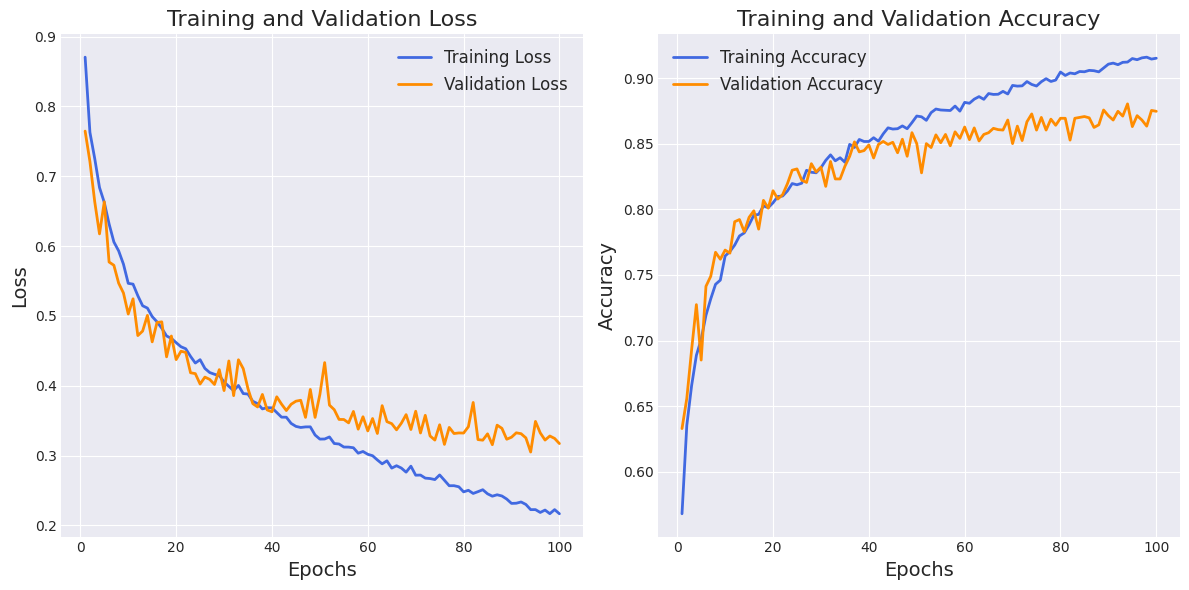

In [122]:
plot_history(history)

Como se puede ver en las gráficas, el modelo alcanza una precisión aproximada de 0.90 en el conjunto de entrenamiento y 0.8747 en el conjunto de validación. No se observan signos de *overfitting*, ya que la pérdida y el *accuracy* en el conjunto de validación siguen tendencias similares a las del conjunto de entrenamiento. Además, la diferencia entre ambas no es significativa en los últimos epochs, lo que indica que el modelo está generalizando bien y no se ha sobreajustado a los datos de entrenamiento.

In [142]:
def evaluate_model(model, dataloader, class_names):
    """
    Evaluate the model using the given data.
    
    Parameters:
    - model: The model to evaluate.
    - dataloader: The DataLoader object containing the test data.
    - class_names: A list of class names corresponding to the target classes.
    
    Returns:
    - A dictionary containing the evaluation
      metrics, a classification report, and 
      the confusion matrix.
    """
    # Set the model to evaluation mode
    model.eval()
    
    # Lists to store the predictions and labels
    all_preds = []
    all_labels = []

    # Disable gradient computation
    with torch.no_grad():
        for batch in dataloader:
            # Get the input data and move it to the device
            X, y = batch
            X, y = X.to(device), y.to(device)
            
            # Forward pass
            y_hat = model(X)
           
            # Get the predicted labels
            preds = y_hat.argmax(dim=1)
            
            # Store the predictions and labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    # Generate a classification report (includes precision, recall, f1-score per class)
    class_report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    
    # Convert the classification report to a DataFrame
    report_df = pd.DataFrame(class_report).transpose()

    # Round the values in the DataFrame to 2 decimal places
    report_df = report_df.round(2)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Store metrics, classification report, and confusion matrix in a dictionary
    evaluation_results = {
        'classification_report': report_df,
        'confusion_matrix': conf_matrix
    }

    return evaluation_results

In [143]:
# Define your class names
selected_classes = ['cat', 'dog', 'frog']

# After training your model, evaluate it
results = evaluate_model(model, testloader, selected_classes)

In [144]:
# Display the classification report
print(results['classification_report'])

              precision  recall  f1-score  support
cat                0.80    0.85      0.83  1000.00
dog                0.88    0.81      0.84  1000.00
frog               0.94    0.95      0.95  1000.00
accuracy           0.87    0.87      0.87     0.87
macro avg          0.87    0.87      0.87  3000.00
weighted avg       0.87    0.87      0.87  3000.00


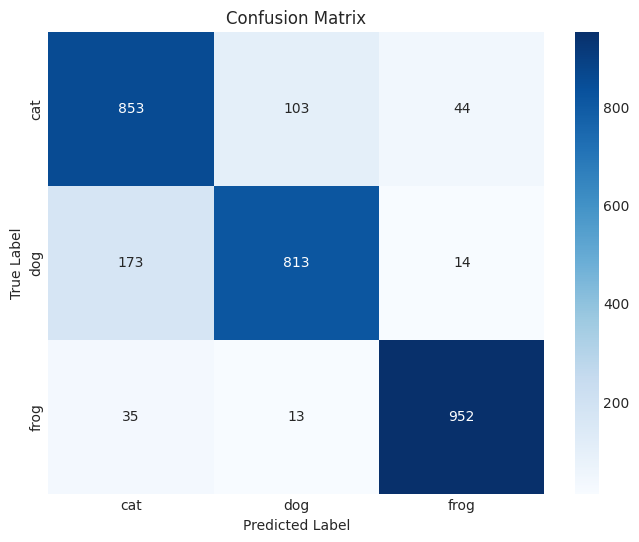

In [145]:
conf_matrix = results['confusion_matrix']

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=selected_classes, yticklabels=selected_classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [162]:
def save_model_with_metrics(model, history, path="", filename_prefix="model", kernel_size=None):
    """
    Save the model with a filename that includes the final validation loss and accuracy.

    Parameters:
    - model: The PyTorch model to be saved.
    - history: A dictionary containing the training history with keys 'train_loss', 'val_loss', 'train_acc', 'val_acc'.
    - path: The directory path where the model will be saved (default is the current directory).
    - filename_prefix: A prefix for the filename (default is "model").
    - kernel_size: Optional kernel size to include in the filename.

    Returns:
    - model_filename: The filename used to save the model.
    """
    # Obtaining the final metrics
    final_train_loss = list(history['train_loss'])[-1]
    final_val_loss = list(history['val_loss'])[-1]
    final_train_acc = list(history['train_acc'])[-1]
    final_val_acc = list(history['val_acc'])[-1]

    # Create a filename for the model
    if kernel_size is not None:
        model_filename = f"{filename_prefix}_kernel{kernel_size}_loss{final_val_loss:.2f}_acc{final_val_acc:.2f}.pth"
    else:
        model_filename = f"{filename_prefix}_loss{final_val_loss:.2f}_acc{final_val_acc:.2f}.pth"

    # Combine the path and filename
    full_path = os.path.join(path, model_filename)

    # Save the model to a file
    torch.save(model.state_dict(), full_path)

    print(f'Model saved as {full_path}')
    return full_path

In [163]:
model_filename = save_model_with_metrics(model, history, path="models", filename_prefix="cifar10_cnn", kernel_size=5)

Model saved as models/cifar10_cnn_kernel5_loss0.32_acc0.87.pth
